In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import multilayer_perceptron
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [6]:
train = pd.read_csv('C:/Users/jdine/.kaggle/competitions/titanic/train.csv')
test = pd.read_csv('C:/Users/jdine/.kaggle/competitions/titanic/test.csv')

print("train shape:" + str(train.shape))
print("test shape:" + str(test.shape))

train shape:(891, 12)
test shape:(418, 11)


In [7]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [8]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [9]:
IDtest = test["PassengerId"]

# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])


C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [10]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [11]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [12]:


## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)



In [13]:


# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()



Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [14]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:


train.dtypes



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [17]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


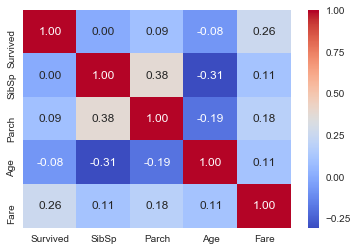

In [18]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

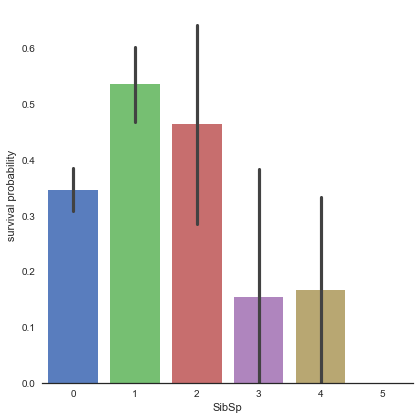

In [19]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")



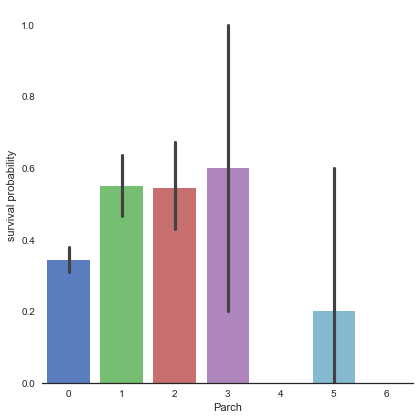

In [20]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


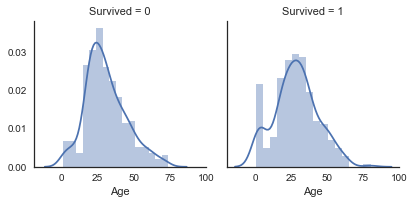

In [21]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

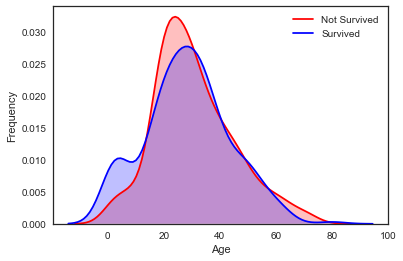

In [22]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [23]:
dataset["Fare"].isnull().sum()

1

In [24]:


#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())



C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


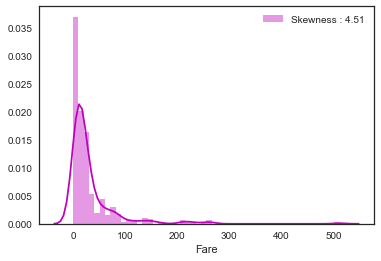

In [25]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


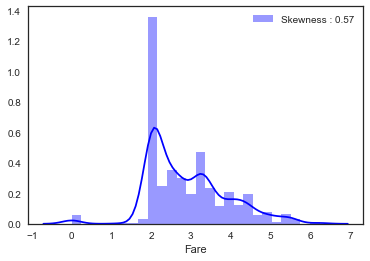

In [26]:


# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")


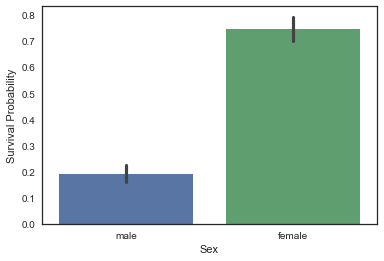

In [27]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

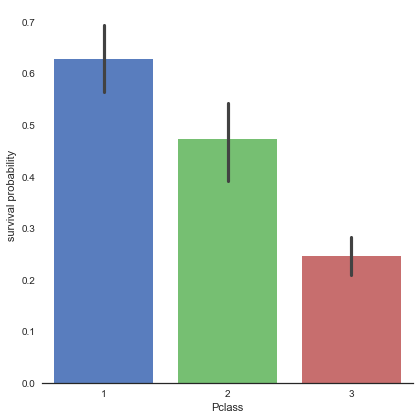

In [28]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

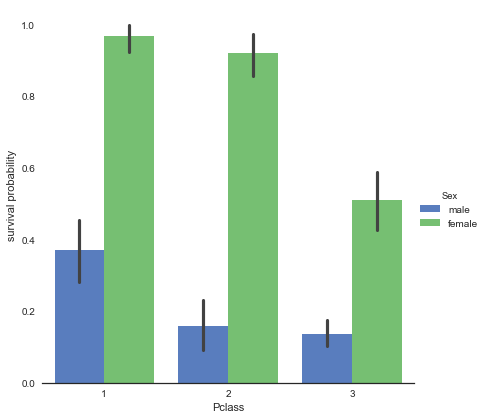

In [29]:


# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")



In [30]:


dataset["Embarked"].isnull().sum()



2

In [31]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

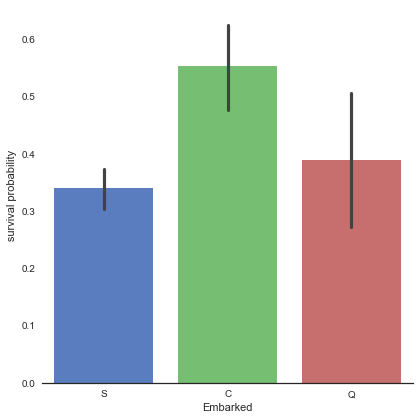

In [32]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

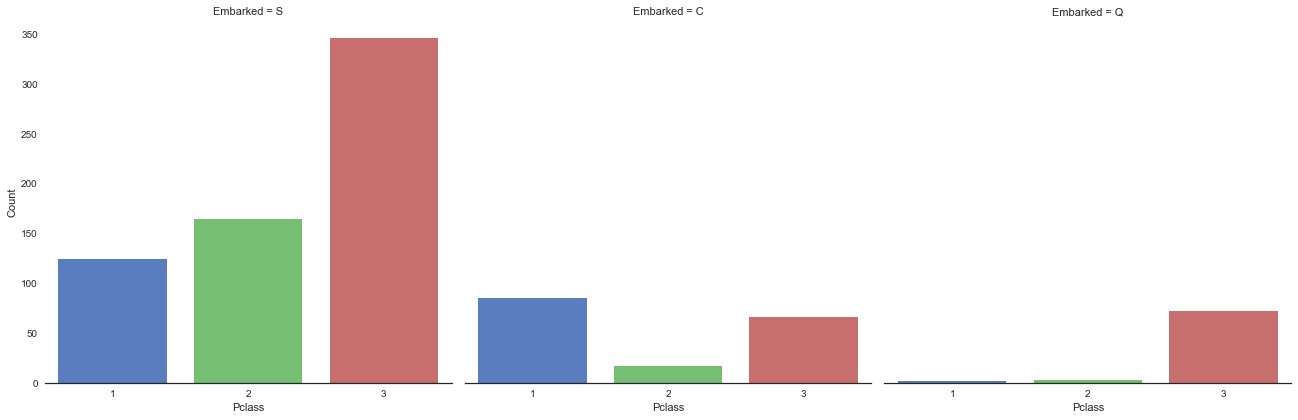

In [33]:


# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")



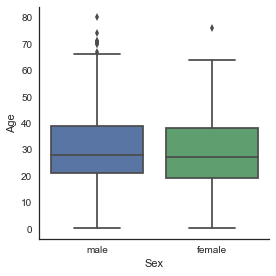

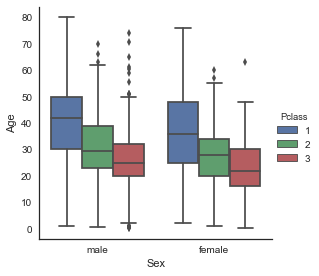

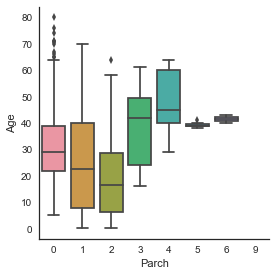

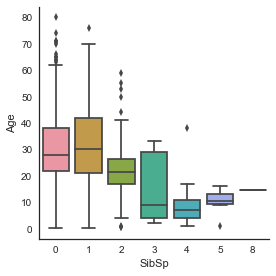

In [34]:


# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")



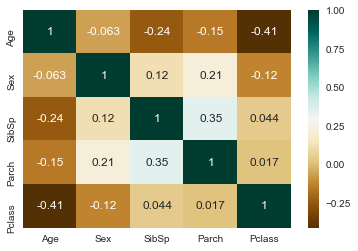

In [35]:


# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [36]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


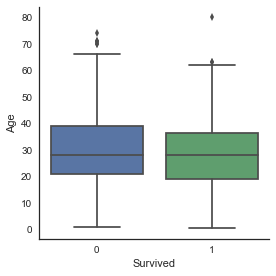

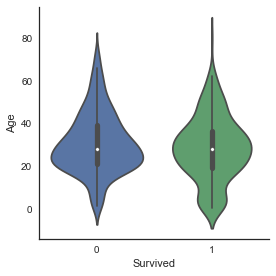

In [37]:


g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")



In [38]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [39]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

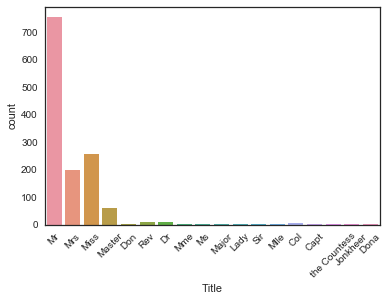

In [40]:


g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 



In [41]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

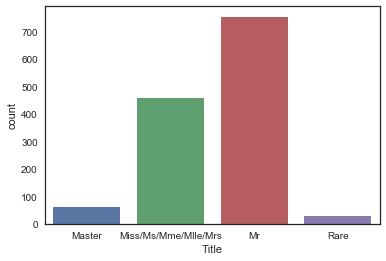

In [42]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

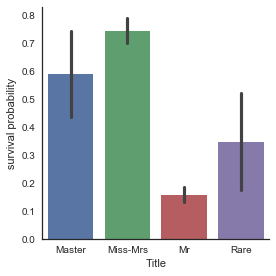

In [43]:


g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")



In [44]:


# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)



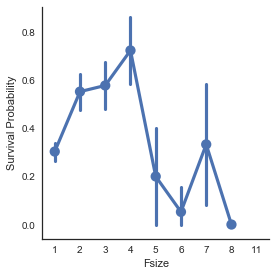

In [45]:


# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1



g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")




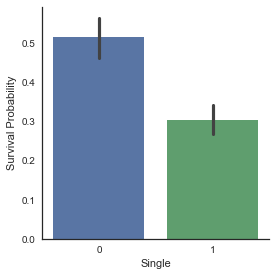

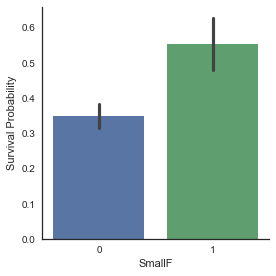

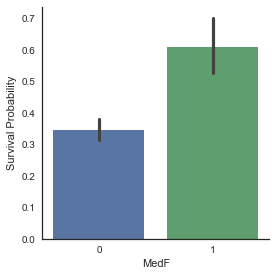

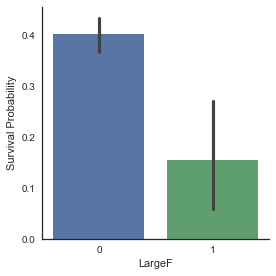

In [46]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)



g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")



In [47]:


# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")



In [48]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


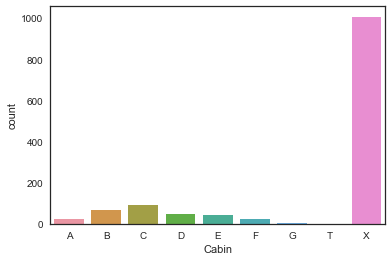

In [49]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])


g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])



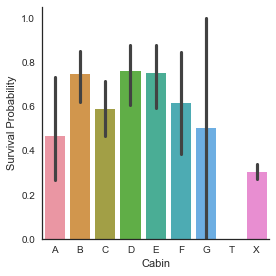

In [50]:


g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")



In [51]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")




In [52]:
dataset["Ticket"].head()



## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()



0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [53]:


dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")


# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")




In [54]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [60]:


## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)


C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


from keras.utils import np_utils

## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

Y_train = np_utils.to_categorical(Y_train,2)
X_train.shape

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from livelossplot import PlotLossesKeras
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle
!pip install h5py
try:
  import h5py
except ImportError:
    h5py = None
    
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_yaml
from keras.models import model_from_json
import numpy
import os

############################################BUILD THE MODEL######################################################################

model = Sequential() #Prime the model
model.add(Dense(881, input_shape=(66,)))#shape from reshaped vector
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(881))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(440))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(440))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(440))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2)) #2 class output
model.add(Activation('sigmoid')) 

#Model parameters. 
NB_EPOCH = 250
#NB_EPOCH = 50
BATCH_SIZE = 50
VERBOSE = 1 #This sets Verbose to true meaning that logging output will be displayed on screen. Verbose = 0 is default and does allow model to run faster.
NB_CLASSES = 2
OPTIMIZER = Adam(lr= .0001)
VALIDATION_SPLIT = .5
Loss = 'binary_crossentropy'

with tf.device('/gpu:0'):
    model.compile(loss = Loss, optimizer= OPTIMIZER, metrics=['accuracy'])
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    history = model.fit(X_train, Y_train, batch_size= BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE,\
                            validation_split= VALIDATION_SPLIT, callbacks=[PlotLossesKeras()])
    
    
    
test_Survived = pd.Series(model.predict_classes(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting123456.csv",index=False)

sess.close()


score = model.evaluate(X_train, Y_train, verbose=VERBOSE)
score[1]

In [61]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)



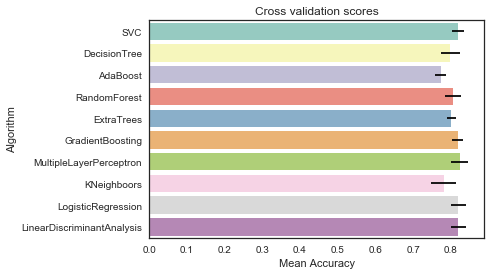

In [62]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [63]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    2.6s finished


In [64]:
from sklearn.grid_search import RandomizedSearchCV

#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_



Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   13.1s finished


0.8297389330306469

In [65]:


# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_



Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   14.3s finished


0.8274687854710556

In [66]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    7.6s finished


0.8206583427922814

In [80]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    8.5s finished


0.8308740068104427

In [95]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_param_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree','kd_tree', 'brute', 'auto'],
                  'leaf_size': [30,50],
                  'p': [1,2],
                  
                  
                 }

gsKNN = GridSearchCV(knn,param_grid = knn_param_grid, cv=kfold, scoring="accuracy", n_jobs= 6, verbose = 1)

gsKNN.fit(X_train,Y_train)

knn_best = gsKNN.best_estimator_

gsKNN.best_score_



Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 1600 out of 1600 | elapsed:    7.9s finished


0.7990919409761634

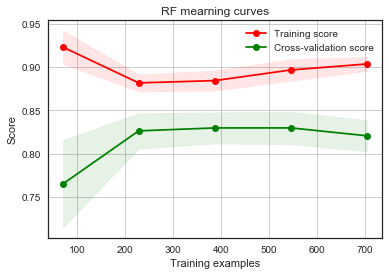

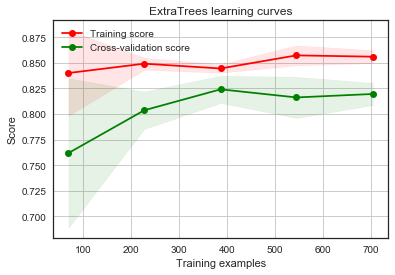

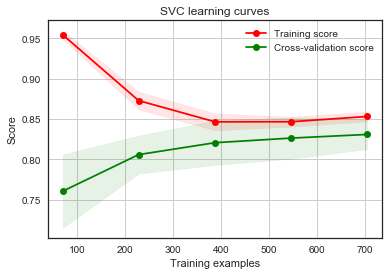

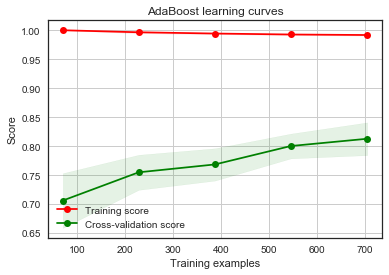

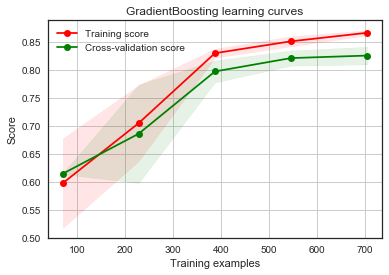

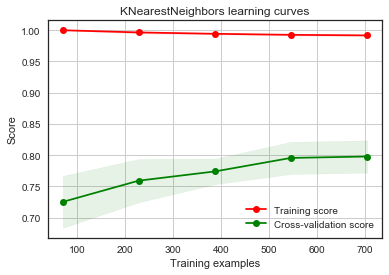

In [96]:


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsKNN.best_estimator_,"KNearestNeighbors learning curves",X_train,Y_train,cv=kfold)




In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best), ("KNN",knn_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:10],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

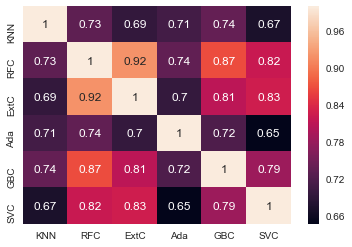

In [97]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_KNN = pd.Series(knn_best.predict(test), name="KNN")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_KNN, test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [98]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best), ('knn',knn_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)


In [101]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")
test_Survived

0      0
1      0
2      0
3      0
4      1
5      0
6      0
7      0
8      1
9      0
10     0
11     0
12     1
13     0
14     1
15     1
16     0
17     0
18     1
19     0
20     0
21     1
22     1
23     0
24     1
25     0
26     1
27     0
28     0
29     0
      ..
388    0
389    0
390    0
391    1
392    1
393    0
394    0
395    1
396    0
397    1
398    0
399    0
400    1
401    0
402    1
403    0
404    0
405    0
406    0
407    0
408    1
409    1
410    1
411    1
412    0
413    0
414    1
415    0
416    0
417    1
Name: Survived, Length: 418, dtype: int32

In [102]:


test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting_titanic.csv",index=False)

